In [1]:
import numpy as np

In [2]:
def iou(box, clusters):
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

In [3]:
def kmeans(boxes, k, dist=np.median):
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [80]:
import os
annot_fps = [
'/media/dh/Data/SGMaritimeDataset/VIS_Onboard_annot_contexted.txt',
'/media/dh/Data/SGMaritimeDataset/VIS_Onshore_annot_contexted.txt',
'/media/dh/Data/SGMaritimeDataset/NIR_annot_contexted.txt',
'/media/dh/Data/SeaShips(7000)/trainval_contexted.txt'
            ]
lines = []
for fp in annot_fps:
    assert os.path.exists(fp)
    with open (fp,'r') as f:
        this_lines = f.readlines()
        lines.extend(this_lines)
    print('{}: {}'.format(os.path.basename(fp), len(this_lines)))

VIS_Onboard_annot_contexted.txt: 63
VIS_Onshore_annot_contexted.txt: 612
NIR_annot_contexted.txt: 385
trainval_contexted.txt: 3500


In [71]:
from PIL import Image

In [72]:
all_bbs = []
for line in lines:
    split = line.strip().replace(';','').split()
    img_path = split[0]
    assert os.path.exists(img_path)
    im = Image.open(img_path)
    iw, ih = im.size
    bbs = split[1:]
    #x_min,y_min,x_max,y_max,class_id
    for bb in bbs:
        x_min, y_min, x_max, y_max, class_id = [int(x) for x in bb.split(',')]
        w = x_max - x_min + 1
        h = y_max - y_min + 1
        nw = w/iw
        nh = h/ih
        all_bbs.append((nw,nh))
all_bbs = np.array(all_bbs)
all_bbs.shape

(11479, 2)

In [73]:
anchors = kmeans(all_bbs, 9)
anchors

array([[0.1578125 , 0.06481481],
       [0.0625    , 0.03518519],
       [0.10104167, 0.0462963 ],
       [0.26197917, 0.10462963],
       [0.0203125 , 0.02222222],
       [0.390625  , 0.17407407],
       [0.05833333, 0.08425926],
       [0.7       , 0.23055556],
       [0.03125   , 0.04074074]])

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

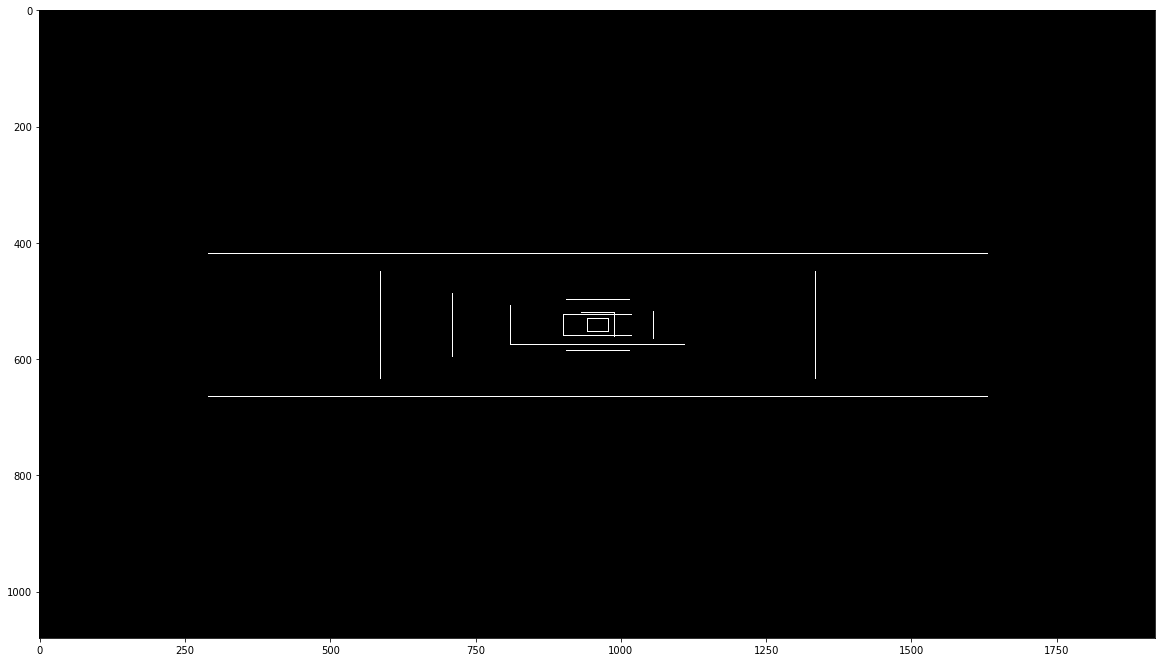

In [75]:
sketchboard = np.zeros((ih, iw, 3))

zoom = 1
for bb in anchors:
    nw, nh = bb
    w = nw * iw * zoom
    h = nh * ih * zoom
    mid_x = int(iw/2+1)
    mid_y = int(ih/2+1)
    x_min = mid_x - int(w/2-1)  
    x_max = mid_x + int(w/2-1)  
    y_min = mid_y - int(h/2-1)  
    y_max = mid_y + int(h/2-1)  
    cv2.rectangle(sketchboard, (x_min, y_min), (x_max, y_max), (255,255,255), thickness=1 )


plt.figure(figsize = (20,20))
plt.imshow(sketchboard)
cv2.imwrite('anchor_viz.png',sketchboard)

In [76]:
anchors_list = list(anchors)
anchors_list.sort(key= lambda x: x[0]*x[1])

In [77]:
n = 3
anchors_scales = [anchors_list[i:i+n] for i in range(0, len(anchors_list), n)]
anchors_scales

[[array([0.0203125 , 0.02222222]),
  array([0.03125   , 0.04074074]),
  array([0.0625    , 0.03518519])],
 [array([0.10104167, 0.0462963 ]),
  array([0.05833333, 0.08425926]),
  array([0.1578125 , 0.06481481])],
 [array([0.26197917, 0.10462963]),
  array([0.390625  , 0.17407407]),
  array([0.7       , 0.23055556])]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

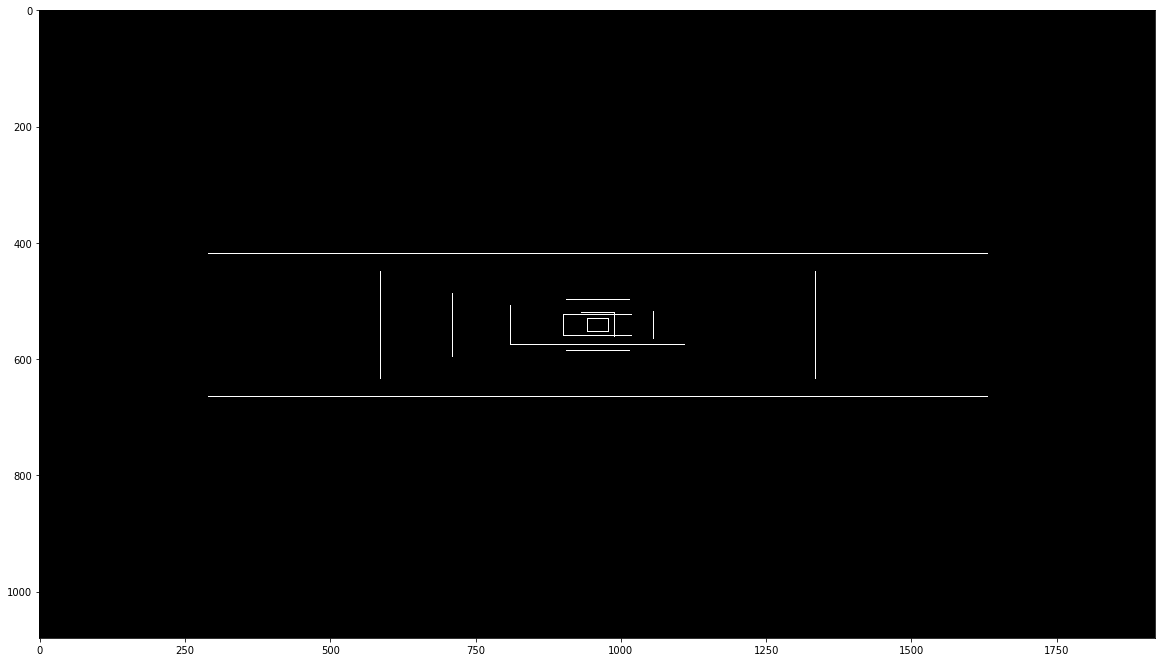

In [78]:
import random

ih, iw = 1080, 1920
sketchboard2 = np.zeros((ih, iw, 3))
zoom = 1
colors = [ (218, 245, 66), (69,245,66), (173, 110, 240)]
for i, anchors in enumerate(anchors_scales):
#     color = (random.randint(100,255), random.randint(100,255), random.randint(100,255))
    color = colors[i]
    for bb in anchors:
        nw, nh = bb
        w = nw * iw * zoom
        h = nh * ih * zoom
        mid_x = int(iw/2+1)
        mid_y = int(ih/2+1)
        x_min = mid_x - int(w/2-1)  
        x_max = mid_x + int(w/2-1)  
        y_min = mid_y - int(h/2-1)  
        y_max = mid_y + int(h/2-1)  
        cv2.rectangle(sketchboard2, (x_min, y_min), (x_max, y_max), color, thickness=1 )


plt.figure(figsize = (20,20))
plt.imshow(sketchboard2)
cv2.imwrite('anchor_viz_scales.png',sketchboard2)

In [87]:
iw, ih = 448, 448

print(anchors_scales)
for anchors in anchors_scales:
    for bb in anchors:
        new_bb = [int(bb[0]*iw), int(bb[1]*ih)]
        print(new_bb)

[[array([0.0203125 , 0.02222222]), array([0.03125   , 0.04074074]), array([0.0625    , 0.03518519])], [array([0.10104167, 0.0462963 ]), array([0.05833333, 0.08425926]), array([0.1578125 , 0.06481481])], [array([0.26197917, 0.10462963]), array([0.390625  , 0.17407407]), array([0.7       , 0.23055556])]]
[9, 9]
[14, 18]
[28, 15]
[45, 20]
[26, 37]
[70, 29]
[117, 46]
[175, 77]
[313, 103]
